In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Patent Graph


In [ ]:
df_original= pd.read_csv("/content/df_top10.csv") #df originale
df = df_original[df_original['CPC Classifications'].apply(lambda x: isinstance(x, str))]

df['Unnamed: 0']

<ipython-input-47-7e0f209e31bf>:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original= pd.read_csv("/content/df_top10.csv") #df originale


0              0
1              1
2              2
3              3
4              4
           ...  
352740    352740
352741    352741
352742    352742
352743    352743
352744    352744
Name: Unnamed: 0, Length: 296639, dtype: int64

In [ ]:
diz = {}

for index, row in df.iterrows():
        patent_key = row['Unnamed: 0']
        cpc = row['CPC Classifications'].split(';;')
        diz[patent_key] = cpc


In [ ]:
diz_1 = {}
for key, values in diz.items():
        new_values = [value[:5] for value in values]
        diz_1[key] = new_values

diz_2 = {}
for k, v in diz_1.items():
        diz_2[k] = v[0].split(",")[0]

patent_cpc = {k: [v] for k, v in diz_2.items()}

#patent_cpc

In [ ]:
import random

In [ ]:
# Estrazione campione casuale 

dimensione_subsample = 10000

dizionario_subsample = dict(random.sample(patent_cpc.items(), dimensione_subsample))

<ipython-input-8-7c2961486d9a>:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  dizionario_subsample = dict(random.sample(patent_cpc.items(), dimensione_subsample))


In [ ]:
#Creazione grafo

In [ ]:
G = nx.Graph()

for nodo in dizionario_subsample:
    G.add_node(nodo)

for nodo1, codici1 in dizionario_subsample.items():
    for nodo2, codici2 in dizionario_subsample.items():
        if nodo1 != nodo2:
            for codice1 in codici1:
                for codice2 in codici2:
                    if codice1.startswith(codice2) or codice2.startswith(codice1):
                        G.add_edge(nodo1, nodo2)
                        break  # Aggiungi l'arco solo una volta



In [ ]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Density:", nx.density(G))
print("Average degree:", sum(dict(G.degree()).values()) / G.number_of_nodes())


Number of nodes: 10000
Number of edges: 814170
Density: 0.016285028502850286
Average degree: 162.834


In [ ]:
#creazione dataset sfruttando statistiche del grafo

In [ ]:
degrees = dict(G.degree())
eigenvector_centrality = nx.eigenvector_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)


#DataFrame con le informazioni dell'arco
edge_data = []
for edge in G.edges():
    source, target = edge
    edge_info = {
        'Source Node': source,
        'Target Node': target,
        'Degree': degrees[target],
        'Eigenvector_Centrality': eigenvector_centrality[target],
        'Closeness_Centrality': closeness_centrality[target],
        'Betweenness_Centrality': betweenness_centrality[target],
        'Degree_Centrality': degree_centrality[target]

    }
    edge_data.append(edge_info)


edge_df = pd.DataFrame(edge_data)

edge_df


,Source Node,Target Node,Degree,Eigenvector_Centrality,Closeness_Centrality,Betweenness_Centrality,Degree_Centrality
0,114588,295956,29,4.614288e-22,0.002900,0.0,0.002900
1,114588,12571,29,4.614288e-22,0.002900,0.0,0.002900
2,114588,80156,29,4.614288e-22,0.002900,0.0,0.002900
3,114588,194610,29,4.614288e-22,0.002900,0.0,0.002900
4,114588,86852,29,4.614288e-22,0.002900,0.0,0.002900
...,...,...,...,...,...,...,...
814165,122162,191670,789,3.557840e-02,0.078908,0.0,0.078908
814166,122162,119459,789,3.557840e-02,0.078908,0.0,0.078908
814167,191670,119459,789,3.557840e-02,0.078908,0.0,0.078908
814168,277440,269192,107,2.833608e-14,0.010701,0.0,0.010701


In [ ]:
edge_df['Company'] = edge_df['Source Node'].map(df_original.set_index('Unnamed: 0')['Applicants'])
edge_df['Sector'] = edge_df['Source Node'].map(df_original.set_index('Unnamed: 0')['CPC Classifications'])

In [ ]:
del edge_df["Source Node"]
del edge_df["Target Node"]

In [ ]:
edge_df['Filtered_CPC'] = edge_df['Sector'].apply(lambda x: x.split(';')[0][:4] if ';' in x else x[:4])
del edge_df['Sector']

In [ ]:
edge_df

,Degree,Eigenvector_Centrality,Closeness_Centrality,Betweenness_Centrality,Degree_Centrality,Company,Filtered_CPC
0,29,4.614288e-22,0.002900,0.0,0.002900,HITACHI LTD,C23C
1,29,4.614288e-22,0.002900,0.0,0.002900,HITACHI LTD,C23C
2,29,4.614288e-22,0.002900,0.0,0.002900,HITACHI LTD,C23C
3,29,4.614288e-22,0.002900,0.0,0.002900,HITACHI LTD,C23C
4,29,4.614288e-22,0.002900,0.0,0.002900,HITACHI LTD,C23C
...,...,...,...,...,...,...,...
814165,789,3.557840e-02,0.078908,0.0,0.078908,HITACHI LTD,H01L
814166,789,3.557840e-02,0.078908,0.0,0.078908,HITACHI LTD,H01L
814167,789,3.557840e-02,0.078908,0.0,0.078908,IBM,H01L
814168,107,2.833608e-14,0.010701,0.0,0.010701,SAMSUNG ELECTRONICS CO LTD,H04W


In [ ]:
del edge_df["Company"]

In [ ]:
edge_df_file = edge_df.to_csv('edge_df.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
class_name = 'Filtered_CPC'

edge_df_encoded = edge_df.copy()

# Codifica la colonna target 'Filtered_CPC'
label_encoder = LabelEncoder()
edge_df_encoded[class_name] = label_encoder.fit_transform(edge_df_encoded[class_name])


attributes = [col for col in edge_df_encoded.columns if col != class_name]
X = edge_df_encoded[attributes].values
y = edge_df_encoded[class_name]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


In [ ]:
#al posto di runnare il codice del random forest con gridsearch, runno prima questo senza grid

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(X_train, y_train)

print(f"model score on training data: {model.score(X_train, y_train)}")
print(f"model score on testing data: {model.score(X_test, y_test)}")

model score on training data: 0.9391756422255609
model score on testing data: 0.9384496085056324


In [ ]:
importances = model.feature_importances_

In [ ]:
importances

array([0.29989959, 0.05584297, 0.32317174, 0.        , 0.32108569])

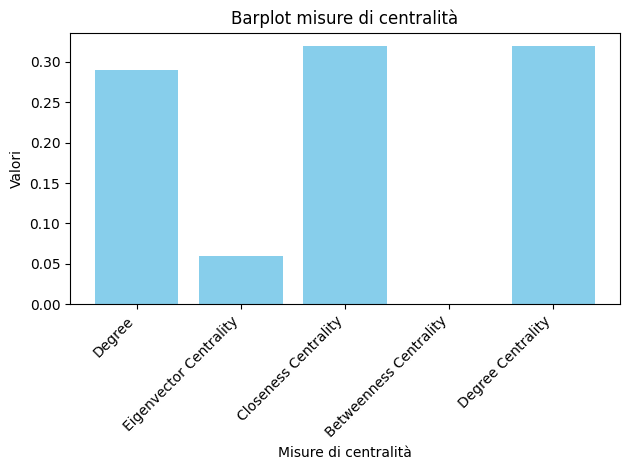

In [ ]:
labels = ['Degree', 'Eigenvector Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'Degree Centrality']
values = [0.29, 0.06, 0.32, 0, 0.32]


plt.bar(labels, values, color='skyblue')

plt.xlabel('Misure di centralità')
plt.ylabel('Valori')
plt.title('Barplot misure di centralità')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Per evitare sovrapposizioni
plt.show()


In [ ]:
# Fare ARIMA su closeness-centrality

In [ ]:
df_subsample = df.sample(n=10000, random_state=42)
#df_subsample

In [ ]:
grafi = []

t = list(range(2000, 2021))
for anno in t:
    dataset_corrente = df_subsample[df_subsample['Publication Year'] == anno]

    # Esegui il codice su ogni dataset
    patent_cpc_dict = {}

    for index, row in dataset_corrente.iterrows():
        patent_key = row['Unnamed: 0']
        cpc = str(row['CPC Classifications']).split(';;')
        patent_cpc_dict[patent_key] = cpc

    new_dict = {}
    for key, values in patent_cpc_dict.items():
        new_values = [value[0] for value in values]
        new_dict[key] = new_values

    settori = {}

    # Itera su ogni brevetto e cpc nel dizionario
    for index, (patent_key, cpc) in enumerate(new_dict.items()):
        settori[index] = tuple(cpc)

    G = nx.Graph()

    for nodo in settori:
        G.add_node(nodo)

    for nodo1, codici1 in settori.items():
        for nodo2, codici2 in settori.items():
            if nodo1 != nodo2:
                for codice1 in codici1:
                    for codice2 in codici2:
                        if codice1.startswith(codice2) or codice2.startswith(codice1):
                            G.add_edge(nodo1, nodo2)
                            break  

    # Aggiungi il grafo corrente alla lista
    grafi.append(G)




In [ ]:
import json

output_file = 'graphs.json'

# Conversione dei grafi in un formato serializzabile per JSON
serialized_graphs = [nx.node_link_data(graph) for graph in grafi]

# Salvo i dati serializzati in un file JSON
with open(output_file, 'w') as file:
    json.dump(serialized_graphs, file)

NameError: ignored

In [ ]:
#-------------DA QUI---------------

In [ ]:
#importare json
import json
input_file = 'graphs.json'

with open(input_file, 'r') as file:
    loaded_data = json.load(file)

# Ricostruire la lista di grafi
lista_grafi = [nx.node_link_graph(graph_data) for graph_data in loaded_data]

In [ ]:
for g in lista_grafi:
  print(g.nodes())
  break

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169]


In [ ]:
# Lista che conterrà i dizionari da convertire in DataFrame
data_list = []

for anno, grafo_temp in enumerate(lista_grafi, start=1):
   
    cpc_degree_dict = {}
    for cpc in grafo_temp.nodes():
        degree = grafo_temp.degree(cpc)
        cpc_degree_dict[cpc] = degree

    # Ordina cpc_degree_dict in ordine alfabetico
    cpc_degree = {k: v for k, v in sorted(cpc_degree_dict.items())}

    data_list.append({"Anno": anno, **cpc_degree})


df_series_t = pd.DataFrame(data_list).set_index("Anno")
df_series_t = df_series_t.dropna(axis=1)

print(df_series_t)


      0    1    2    3    4    5    6    7    8    9    ...  160  161  162  \
Anno                                                    ...                  
1      41  119   41   73   73   73   74   73  150   41  ...  109   74   92   
2      83   83   53   83   83   36   67  153   53  105  ...  105  153  153   
3      96   96   27  123  176   22  117   59  123  157  ...  188  188   96   
4     114   37   98   37   98  114   98   98   98  178  ...   98  114   98   
5     102  191  134  191  102  191  134  191  102  134  ...  102   29  134   
6     121   19  121  121   33  148  164  148  121  193  ...  121  252  256   
7      84  107  107  165  165  107   95   84  239  107  ...  168   73  107   
8     192   38  113  143  214  143  143   38  192  113  ...  116   70  214   
9     163  138   29   39   73  138  187  187   73  187  ...  138  138   73   
10    101  157  237   63  221  101   63  101   27  221  ...  221  157   27   
11     97  149  149  149  149   97  149  149  149   49  ...   97

In [ ]:
valori_preselezionati = [70, 26, 29, 140, 74]

# Filtra il DataFrame mantenendo solo le righe con valori presenti nella lista
df_final_ = df[df['Unnamed: 0'].isin(valori_preselezionati)]
df_final_['Filtered_CPC'] = df_final_['CPC Classifications'].apply(lambda x: x.split(';')[0][:4] if ';' in x else x[:4])
pd.DataFrame(df_final_['Filtered_CPC'])



<ipython-input-63-04697221343e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_['Filtered_CPC'] = df_final_['CPC Classifications'].apply(lambda x: x.split(';')[0][:4] if ';' in x else x[:4])


,Filtered_CPC
26,C08G
29,F01D
70,F01D
74,C23C
140,C22C


In [ ]:
# Calcola la media dei valori di ogni colonna
media_colonne = df_series_t.mean()

# Converte la serie risultante in un array NumPy
array_media_colonne = media_colonne.to_numpy()

label_colonne = df_series_t.columns

# Creazione del dizionario associando le label alle medie
dizionario_media_colonne = dict(zip(label_colonne, array_media_colonne))

# Filtro le 5 chiavi con valori più alti
top_5_chiavi = dict(sorted(dizionario_media_colonne.items(), key=lambda item: item[1], reverse=True)[:5])




In [ ]:
top_5_chiavi


{70: 208.47619047619048,
 26: 207.52380952380952,
 29: 207.52380952380952,
 140: 204.14285714285714,
 74: 203.66666666666666}

In [ ]:
df_filtrato= df_series_t[list(top_5_chiavi.keys())]

print("DataFrame Conservato:")
print(df_filtrato)

DataFrame Conservato:
       70   26   29  140   74
Anno                         
1     119   73   74  109   41
2     105  105  153  161  109
3     123  147   96  123  123
4     114   98  114  178  114
5     134  106  143  134  102
6      45  176  231   62  148
7     107  107   26  165  239
8     214   73  177  214  214
9     220  138  278  187  187
10    157  221  157   63  157
11    149  218   49  181  149
12    227  111  227  167  111
13    197  270  270  109  197
14    332  360  153  272  153
15    291  291  145  212  341
16    277  277  317  277  277
17    301  378  341  301  301
18    414  162  414  325  203
19    187  425  328  425  400
20    356  313  356  313  402
21    309  309  309  309  309


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ADF Statistic: -2.142595164605853
p-value: 0.22773521959868687
Critical Values: {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125}


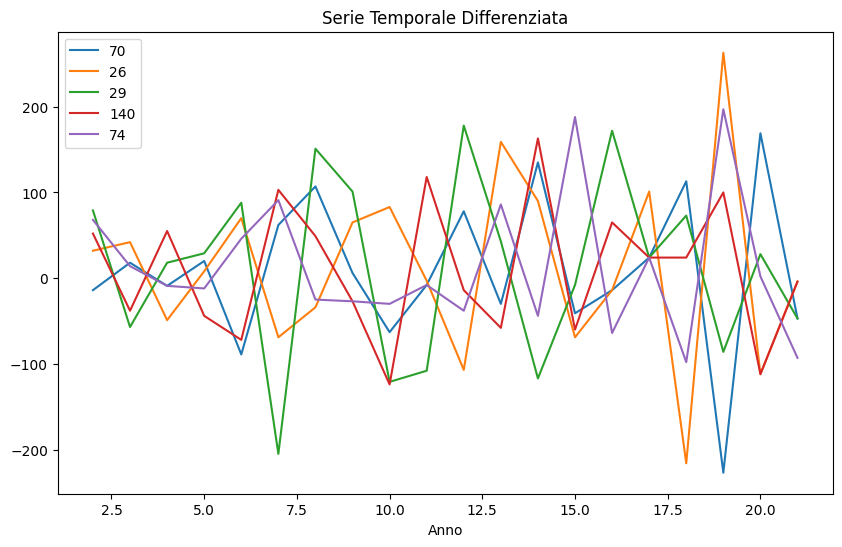

ADF Statistic (differenziata): -2.142595164605853
p-value (differenziata): 0.22773521959868687
Critical Values (differenziata): {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125}


In [ ]:
for col in df_filtrato.columns:
    # Verifica la stazionarietà della serie temporale
    result = adfuller(df_filtrato[col])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Se la serie temporale non è stazionaria, applico la differenziazione per renderla stazionaria
if result[1] > 0.05:
  df_diff = df_filtrato.diff().dropna()

# Grafico della serie temporale differenziata
df_diff.plot(figsize=(10, 6))
plt.title('Serie Temporale Differenziata')
plt.show()

# Ricalcolo del test di stazionarietà sulla serie temporale differenziata
result_diff = adfuller(df_filtrato[col])
print("ADF Statistic (differenziata):", result_diff[0])
print("p-value (differenziata):", result_diff[1])
print("Critical Values (differenziata):", result_diff[4])




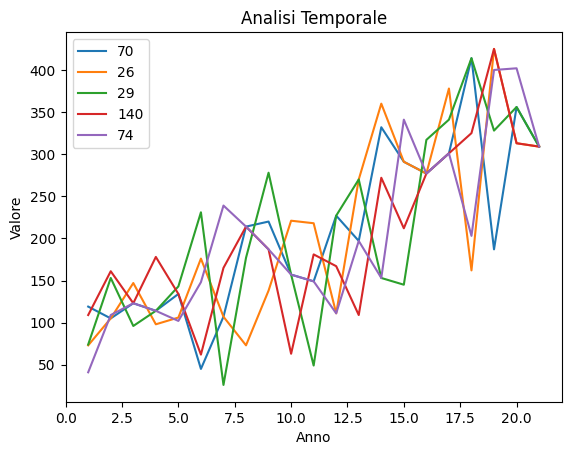

In [ ]:
df_filtrato.plot(legend=True)
plt.xlabel('Anno')
plt.ylabel('Valore')
plt.title('Analisi Temporale')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

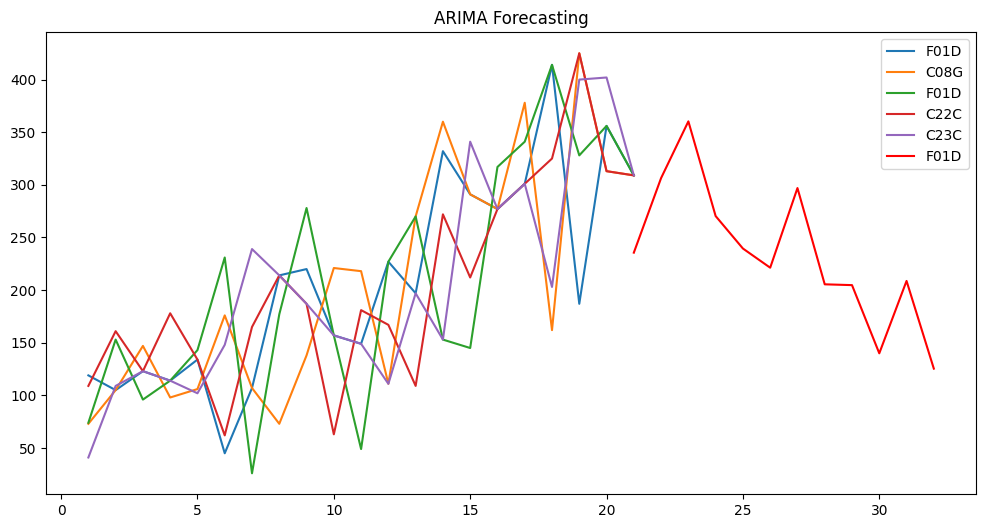

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# I seguenti parametri ARIMA dovrebbero scegliersi in base ai grafici ACF e PACF, ma qui sono stati scelti casualmente 
p = 4  # Ordine AR
d = 3  # Ordine di differenziazione
q = 2  # Ordine MA

# Addestramento di ARIMA
for col in df_filtrato.columns:
    model = ARIMA(df_filtrato[col], order=(p, d, q))
    fit_model = model.fit()

# Previsioni con il modello ARIMA
forecast_steps = 12  # Numero di passi di previsione
forecast = fit_model.get_forecast(steps=forecast_steps)

forecast_index = forecast.predicted_mean.index

# Nomi da assegnare alle etichette della legenda
legend_labels = ['F01D', 'C08G', 'F01D', 'C22C', 'C23C'] * len(df_filtrato.columns) + ['Previsioni']

plt.figure(figsize=(12, 6))
for col in df_filtrato.columns:
    plt.plot(df_filtrato.index, df_filtrato[col], label='Dati Osservati')

plt.plot(forecast_index, forecast.predicted_mean, color='red', label='Previsioni')

plt.legend(legend_labels)

plt.title('ARIMA Forecasting')
plt.show()
